# specbymass.py

In [1]:
# This demo shows how to make a plot of the fractional contribution of differnt
# stellar mass ranges to the total spectrum, for different properties of the
# stellar population.  There is also some use of the filter objects.

from itertools import product
import numpy as np
import matplotlib.pyplot as pl
import fsps

In [2]:
# make an SPS object with interpolation in metallicity enabled, and
# set a few parameters
sps = fsps.StellarPopulation(zcontinuous=1)
sps.params['imf_type'] = 0   # Salpeter IMF
sps.params['sfh'] = 1  # Tau model SFH

In [3]:
# Get a few filter transmission curves
filterlist = {'galex_fuv': 'FUV', 'galex_nuv': 'NUV', 'sdss_u': 'u',
              'sdss_g': 'g', 'sdss_i': 'i', '2mass_j': 'J'}
filters = [fsps.filters.get_filter(f) for f in filterlist]

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [4]:
# This is the main function
def specplots(tage=10.0, const=1.0, tau=1.0, neb=False, z=0.0, savefig=True,
              masslims=[1.0, 3.0, 15.0, 30.0, 120.0], **kwargs):
    """Make a number of plots showing the fraction of the total light due to
    stars within certain stellar mass ranges.

    :param tage:
        The age of the stellar population

    :param const:
        0 or 1.  fraction of SF in constant SFR fraction

    :param tau:
        If const is 0, this is the decay timescale (in Gyr) of the
        exponentially declining SFR.

    :param neb:
        Boolean.  Whether to include the contribution of emission lines.

    :param z:
        Metallicity, in units of log Z/Z_\odot

    :param masslims:
        The edges of the stellar mass bins to plot, in solar masses.

    :param savefig:
        If True save the figures to pdfs

    :returns cfig:
        matplotlib figure giving a plot of the spectrum of stars *less than* a
        given upper stellar mass limit

    :returns dfig:
        matplotlib figure giving a plot of the spectrum of stars in given mass
        ranges.

    :returns ffig:
        matplotlib figure giving a plot of the fraction of total flux due to
        stars in given mass ranges, as a function of wavelength.
    """
    # Set the FSPS params
    sps.params['const'] = const
    sps.params['tau'] = tau
    sps.params['add_neb_emission'] = neb
    sps.params['masscut'] = 120
    sps.params['logzsol'] = z
    # Try to set any extra params
    for k, v in kwargs.items():
        try:
            sps.params[k] = v
        except(KeyError):
            pass

    # Make a pretty string with the FSPS parameters
    sfh = {1: 'Constant SFR', 0: r'$\tau_{{SF}}={}$'.format(sps.params['tau'])}
    sfhname = {1: 'const', 0: 'tau{}'.format(sps.params['tau'])}
    name = '{}_z{}_neb{}'.format(sfhname[int(const)], z, neb)

    # get the total spectrum due to *all* stars
    wave, spec_tot = sps.get_spectrum(tage=tage)

    # Set up stellar mass ranges and arrays to hold output spectra
    mspec = np.zeros([len(sps.wavelengths), len(masslims)])
    dmspec = np.zeros_like(mspec)

    # set up figure and axis objects
    cfig, cax = pl.subplots(figsize=(12.4, 7.5))
    dfig, dax = pl.subplots(figsize=(12.4, 7.5))
    ffig, fax = pl.subplots(figsize=(12.4, 7.5))
    [ax.set_xlim(0.9e3, 1e4) for ax in [cax, fax, dax]]

    # Loop over upper mass limits, generating spectrum for each one
    for i, mc in enumerate(masslims):
        # set the upper stellar mass limit
        sps.params['masscut'] = mc
        # get the spectrum at age = tage and store it
        w, spec = sps.get_spectrum(tage=tage)
        mspec[:, i] = spec.copy()
        # plot the spectrum due to stars less massive than the limit
        cax.plot(w, spec, label='M < {}'.format(mc))

        if i == 0:
            # Plot the lowest mass bin spectrum
            dax.plot(w, spec, label='{} < M < {}'.format(0.08, mc))
            fax.plot(w, spec / spec_tot, label='{} < M < {}'.format(0.08, mc))
            # skip the rest of the loop
            continue

        # Subtract the spectrum from the last upper limit to ge tthe
        #  spectrum due to stars within the bin
        dmspec[:, i] = spec - mspec[:, i-1]
        # Plot it
        label = '{} < M < {}'.format(masslims[i-1], mc)
        dax.plot(w, dmspec[:, i], label=label)
        # Plot the total spectrum
        if mc == masslims[-1]:
            dax.plot(w, spec, label='Total', color='black')

        # plot the fractional
        fax.plot(w, dmspec[:, i] / spec_tot, label=label)

    # prettify the axes, titles, etc
    [ax.legend(loc=0) for ax in [cax, dax, fax]]
    [ax.set_xlabel('$\lambda (\AA)$') for ax in [cax, dax, fax]]
    [ax.set_ylabel('$F_\lambda$') for ax in [cax, dax]]
    [ax.set_yscale('log') for ax in [cax, dax]]
    [ax.set_ylim(1e-20, 1e-14) for ax in [cax, dax]]
    fstring = 'Age = {} Gyr, {}, log$Z/Z_\odot$={}'
    vals = 10.0, sfh[int(sps.params['const'])], sps.params['logzsol']
    [ax.set_title(fstring.format(*vals)) for ax in [cax, dax, fax]]
    fax.set_ylabel('$F/F_{tot}$')

    # plot filter transmission curves as shaded regions
    for f in filters:
        wavelength, transmission = f.transmission
        tmax = transmission.max()
        wmax = wavelength[transmission.argmax()]
        fax.fill_between(wavelength, transmission / tmax * 0.8,
                         alpha=0.3, color='grey')
        fax.text(wmax, 0.83, filterlist[f.name], fontdict={'size': 16})

    if savefig:
        # save to pdf
        cfig.savefig('cspec_'+name+'.pdf')
        dfig.savefig('dspec_'+name+'.pdf')
        ffig.savefig('fspec_'+name+'.pdf')

    return cfig, dfig, ffig

/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_7364/768061628.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ff.show()


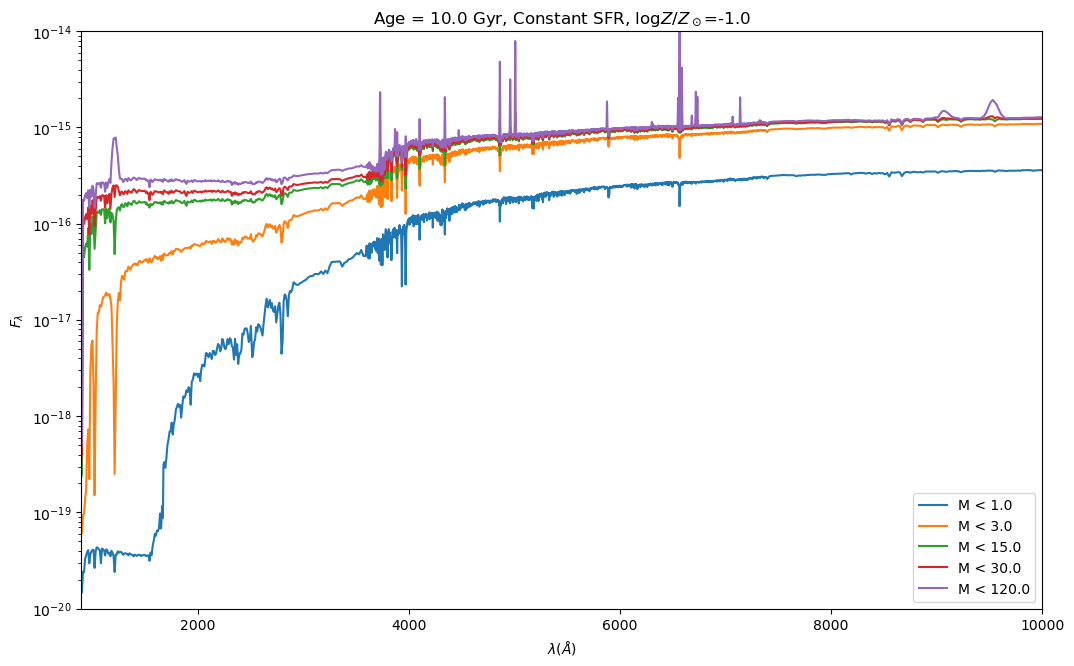

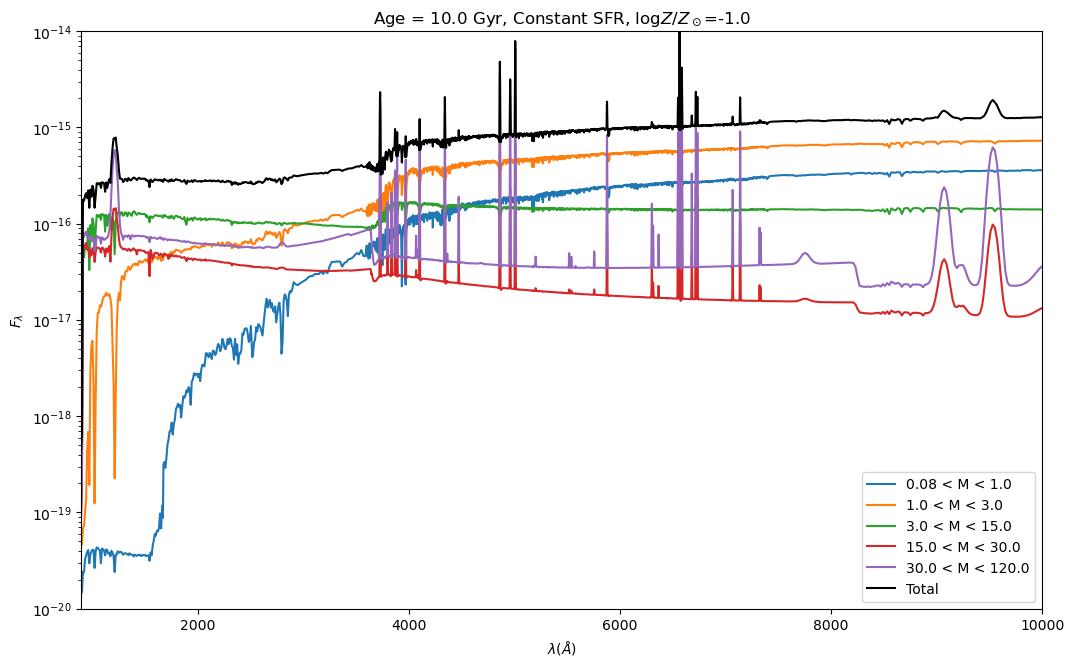

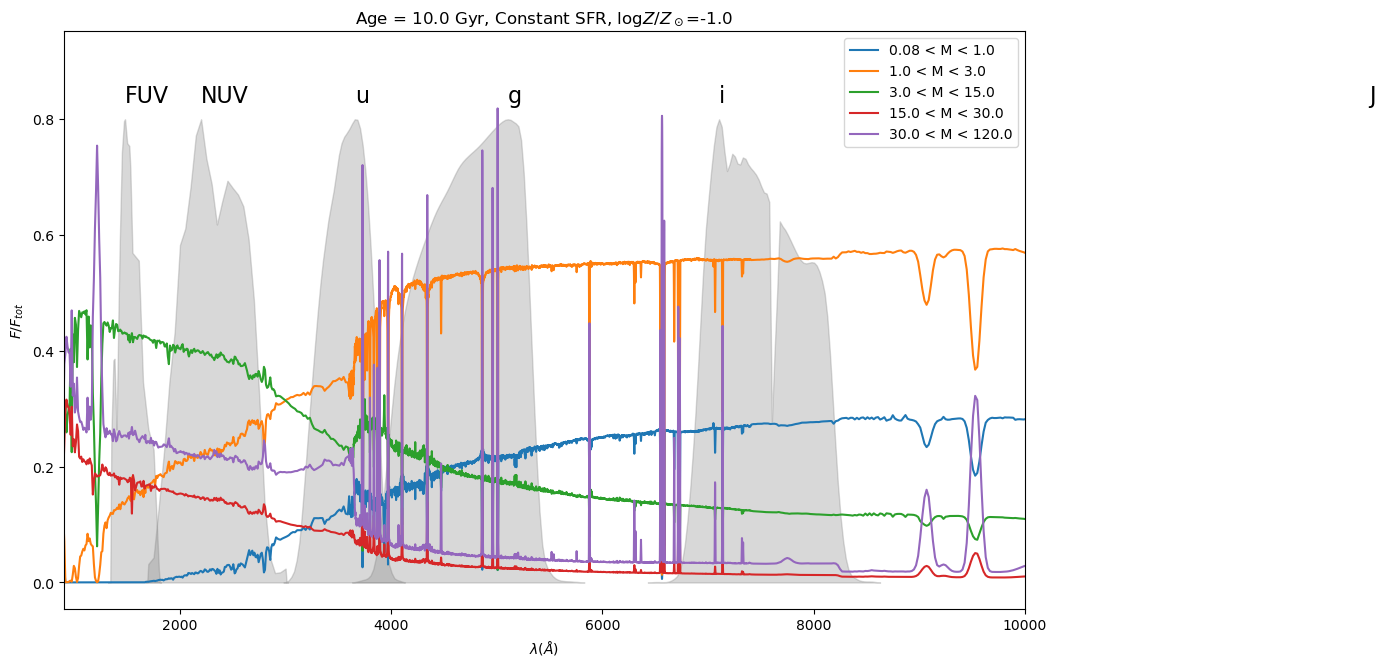

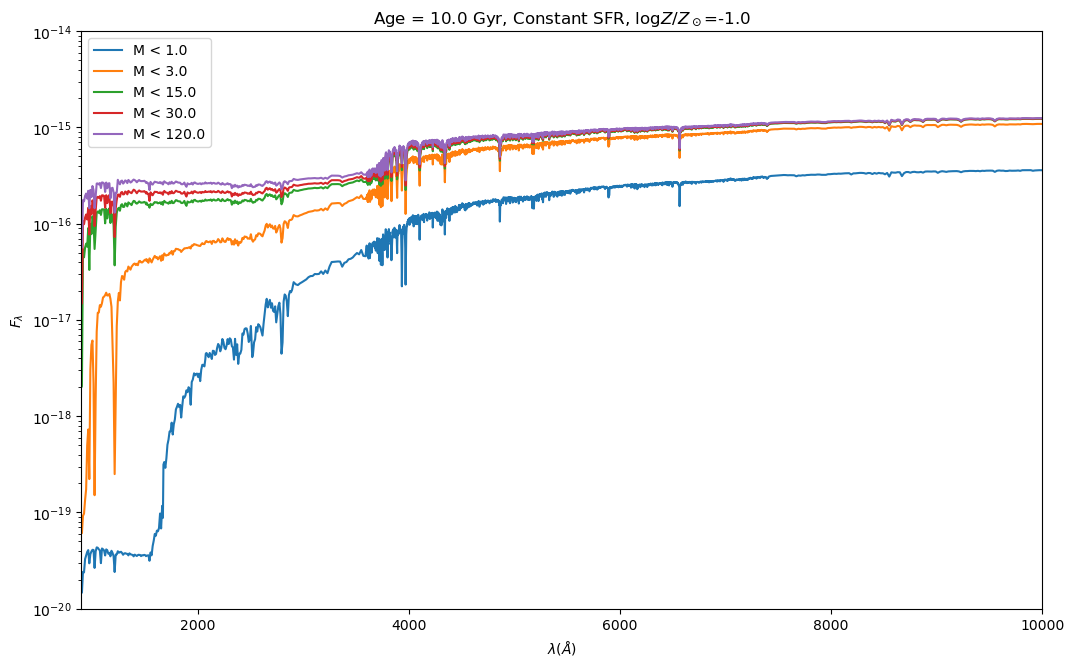

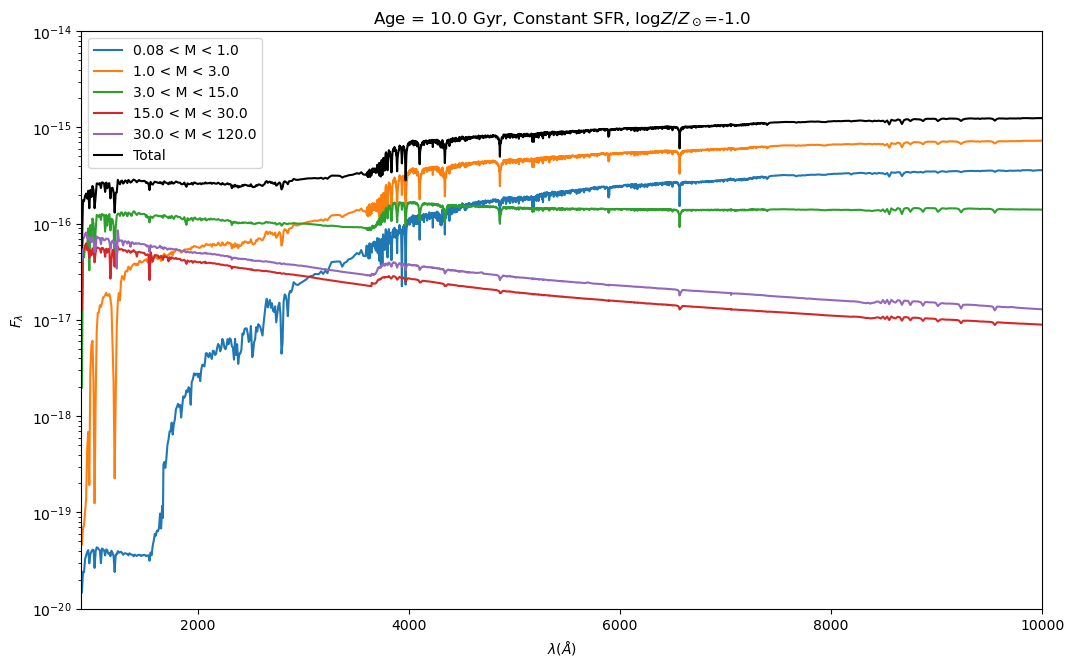

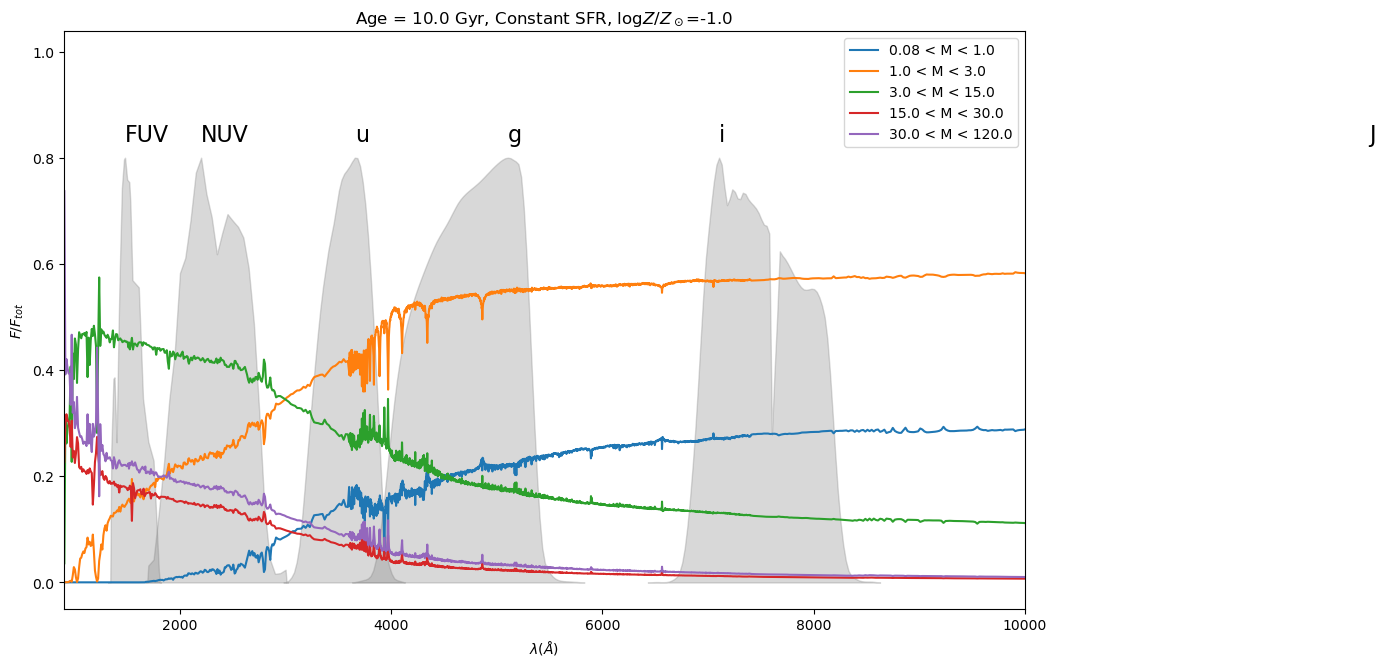

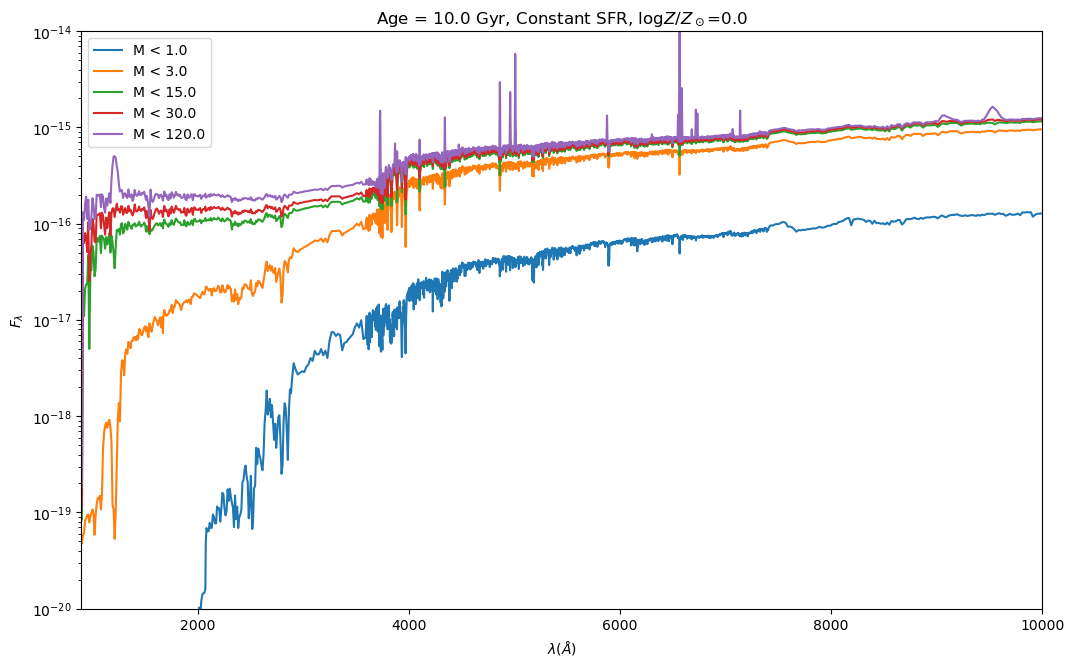

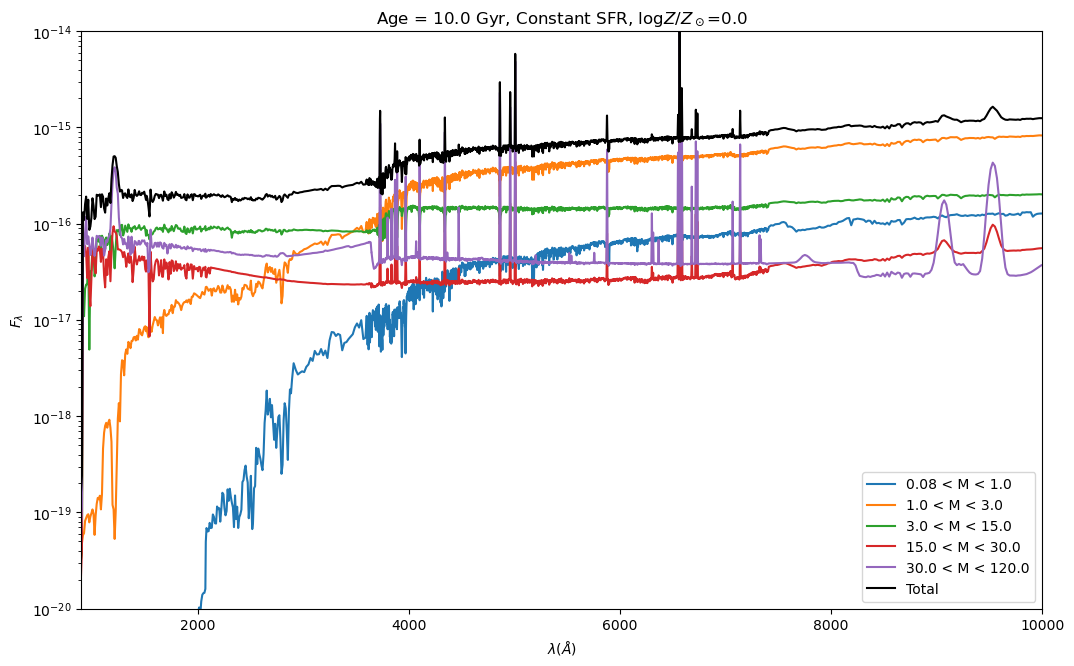

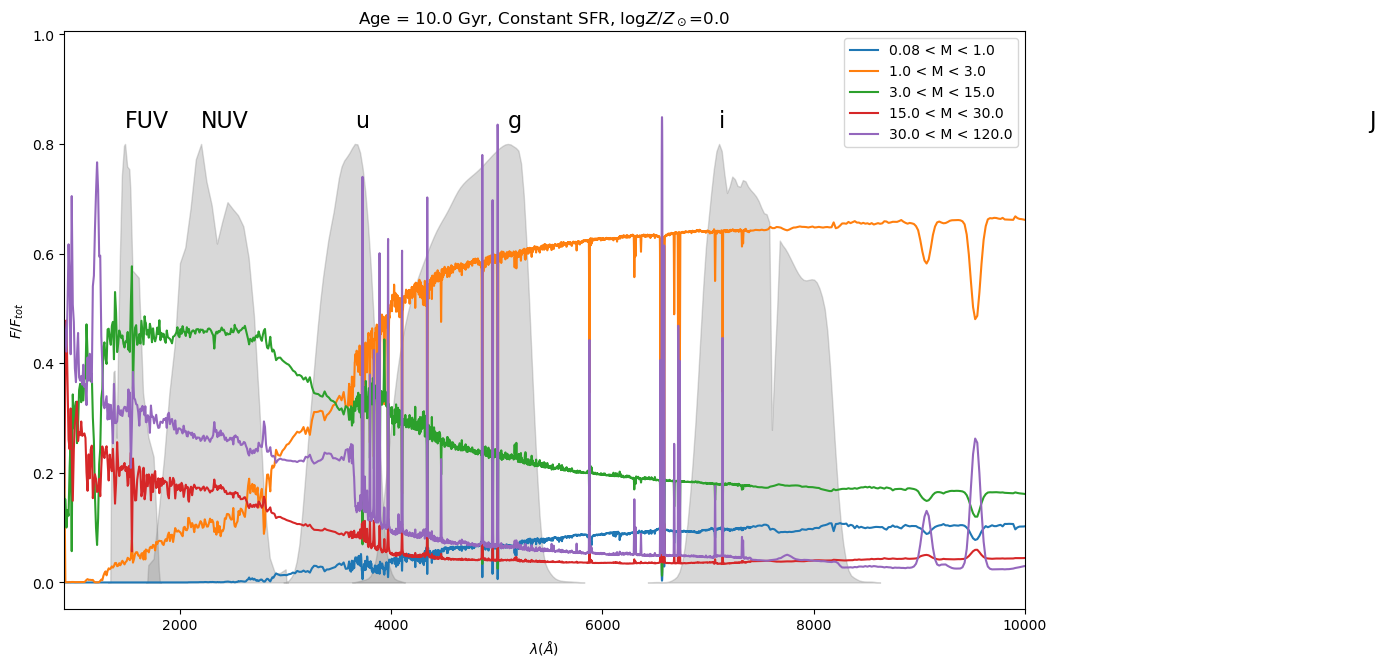

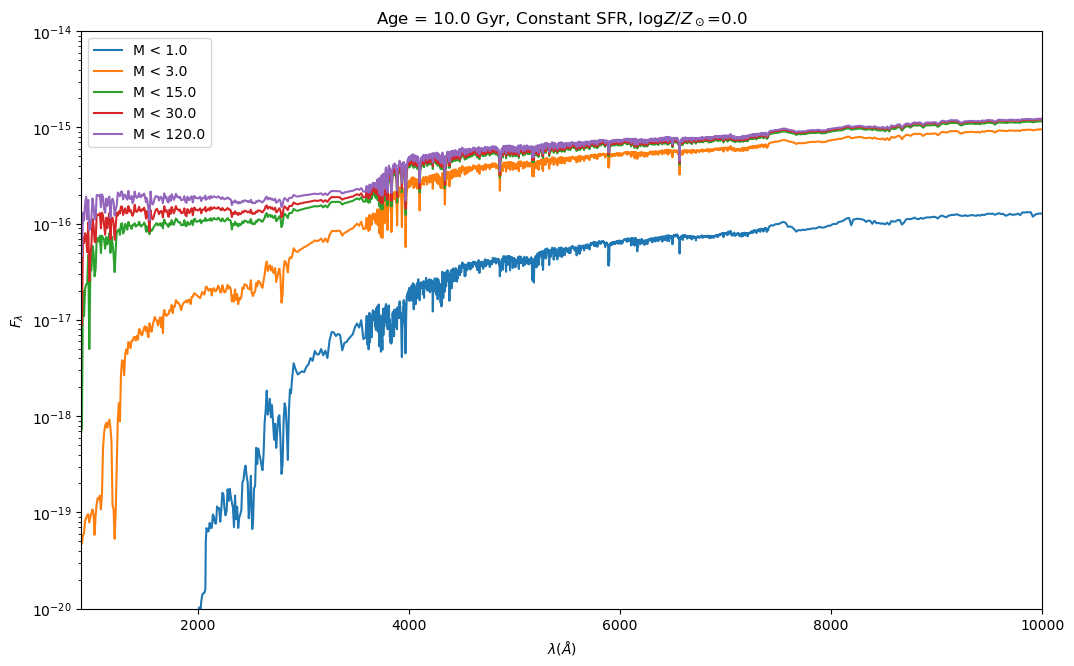

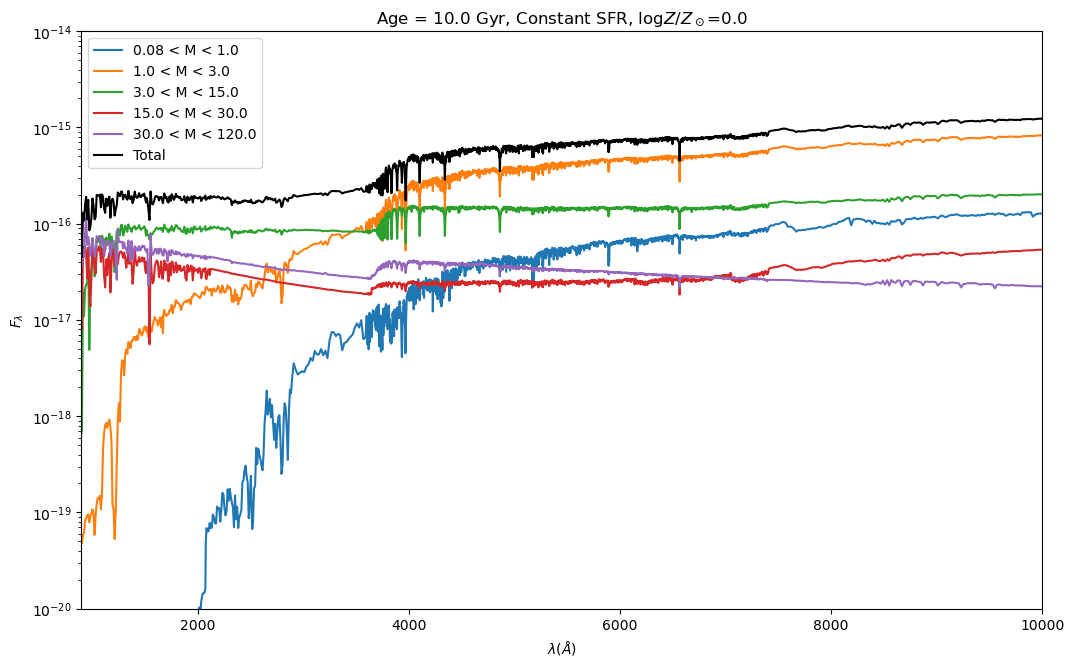

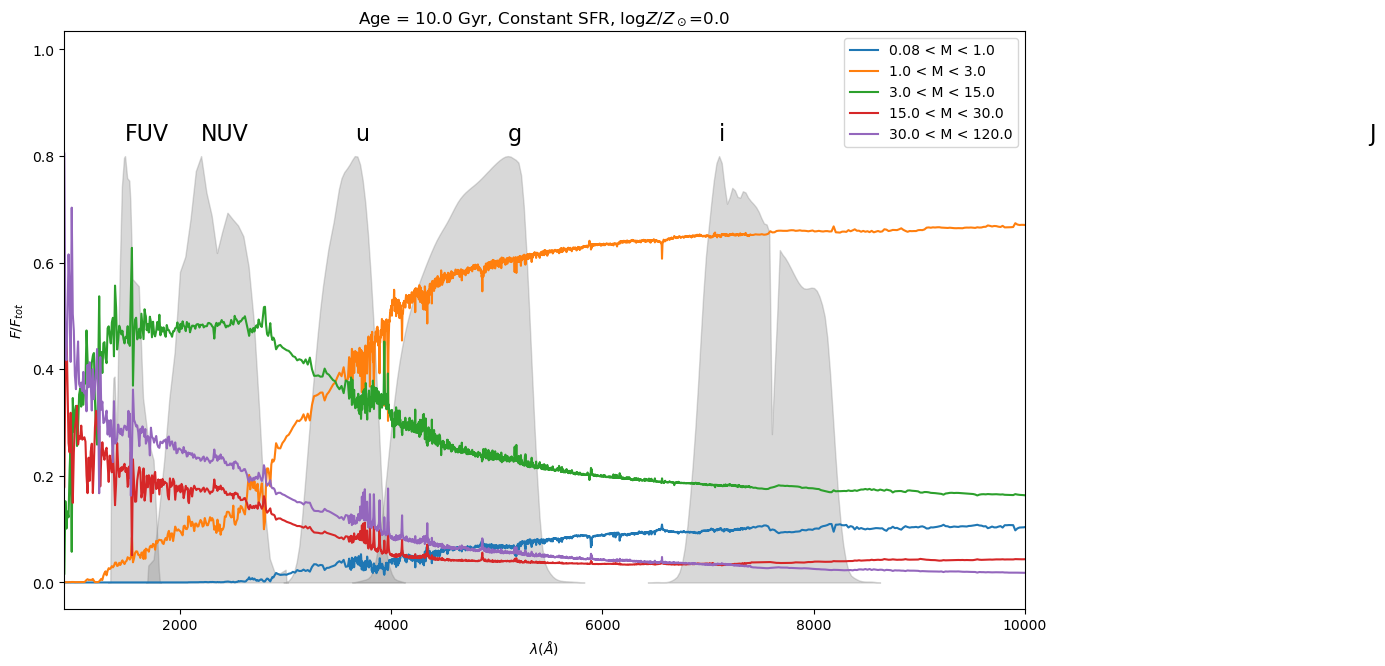

In [5]:
# set the stellar population age
tage = 10.0  # in Gyr

# Parameters to loop over
# ----------
# log Z/Z_sun
zs = [-1.0, 0.0]
# Whether to include nebular emission
nebs = [True, False]
# Fraction of SF in constant SFR.  should be 0 or 1 for these plots
const = [1.0]

# loop over parameters, and show the fractional plot
for z, n, c in product(zs, nebs, const):
    cf, df, ff = specplots(tage=tage, z=z, const=c, neb=n, savefig=False)
    ff.show()